# Import needed modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#5000 images for training
train_dataset = ImageFolder('/media/husnain/nain/Programming/Python/UNI/Brain-Tumor/brain_tumor_dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


#1300 images for validation
val_dataset = ImageFolder('/media/husnain/nain/Programming/Python/UNI/Brain-Tumor/brain_tumor_dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


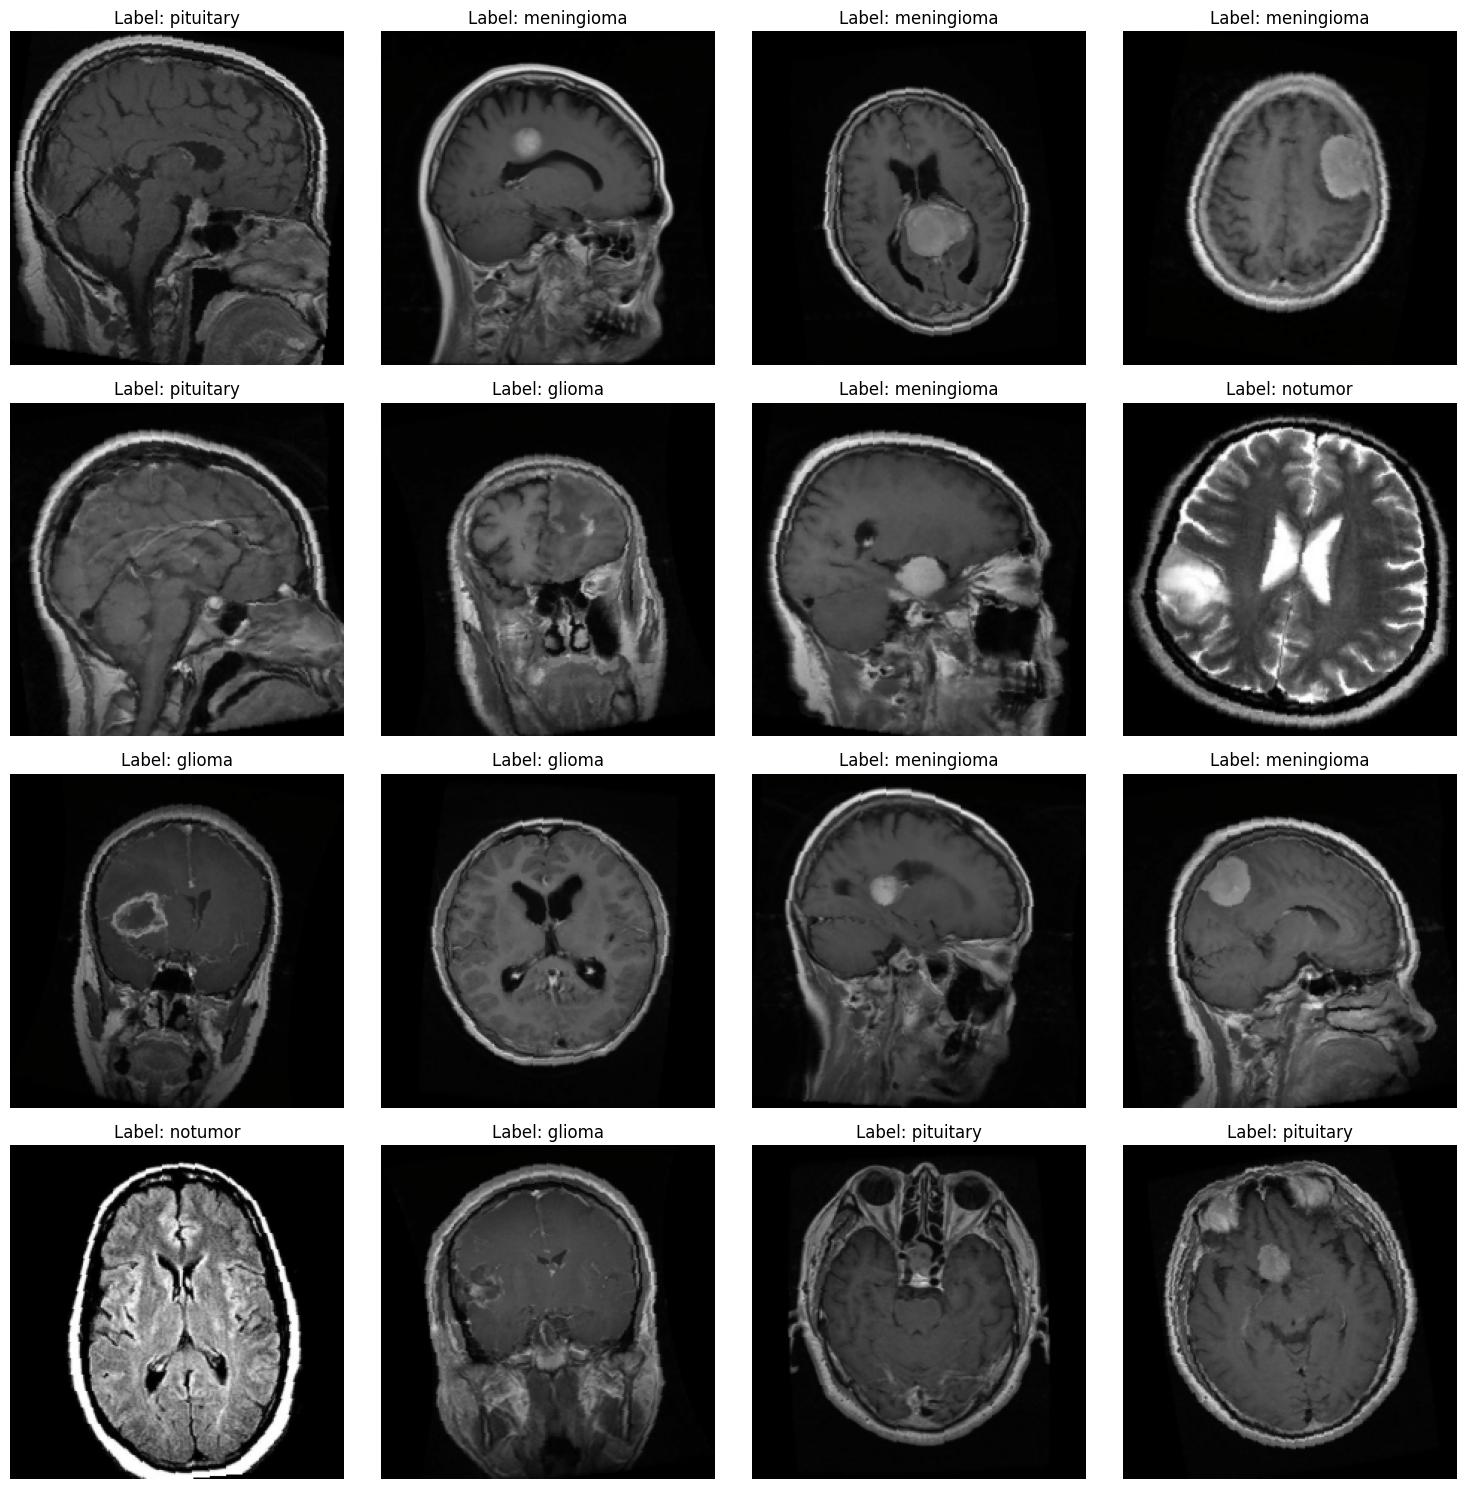

In [4]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [7]:

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


Epoch [1/10], Training Loss: 247.3181, Training Accuracy: 77.56%, Validation Loss: 0.5328, Validation Accuracy: 80.24%
Epoch [2/10], Training Loss: 113.0496, Training Accuracy: 88.53%, Validation Loss: 0.3422, Validation Accuracy: 86.65%
Epoch [3/10], Training Loss: 75.4708, Training Accuracy: 92.02%, Validation Loss: 0.2397, Validation Accuracy: 91.08%
Epoch [4/10], Training Loss: 56.0515, Training Accuracy: 94.14%, Validation Loss: 0.2563, Validation Accuracy: 91.38%
Epoch [5/10], Training Loss: 42.0024, Training Accuracy: 95.96%, Validation Loss: 0.1468, Validation Accuracy: 95.19%
Epoch [6/10], Training Loss: 32.4872, Training Accuracy: 96.97%, Validation Loss: 0.1519, Validation Accuracy: 95.65%
Epoch [7/10], Training Loss: 28.5214, Training Accuracy: 97.32%, Validation Loss: 0.3954, Validation Accuracy: 91.91%
Epoch [8/10], Training Loss: 19.7299, Training Accuracy: 98.07%, Validation Loss: 0.1779, Validation Accuracy: 95.73%
Epoch [9/10], Training Loss: 24.9148, Training Accurac

# Model Evaluation

In [8]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 96.41%


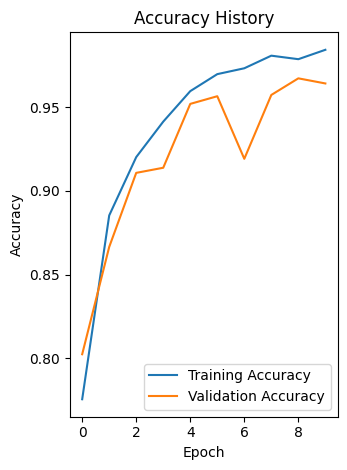

In [9]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

# Saving Model

In [12]:
torch.save(model, 'best-model-brain-tumor.pt')
print('Model Saved Sucssfully !')

Model Saved Sucssfully !
